Import Libraries

In [81]:
#from google.colab import drive
#drive.mount('/content/drive')

In [82]:
#!pip install tensorflow-io

In [83]:
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow import keras
from keras import backend as k

# 1. Process Audio into Spectogram

Variables:
batch: the process of splitting the training dataset in n batches (mini-batches),
classes: number of classifications (labels) of the data,
epochs: variations, one epoch is one forward pass + one backward pass on training

In [84]:
#batch_size = 20
num_classes = 10
epochs = 4

a function that returns audio in numeric representation

In [85]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    #wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

Check a sample of audio

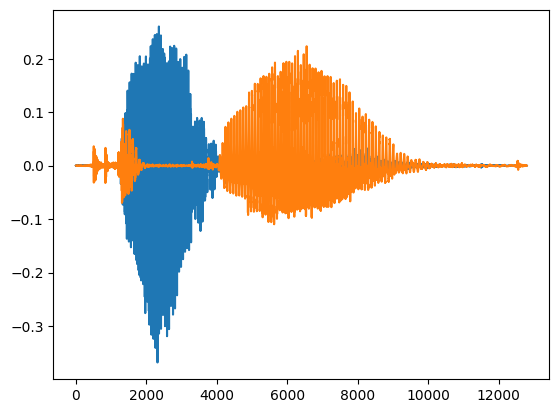

In [86]:
TRAIN_FILE = os.path.join('/content','drive','MyDrive','audio-data','Train','C03n_0.wav')
TEST_FILE = os.path.join('/content','drive','MyDrive','audio-data','Test','C04n_2.wav')
wave = load_wav_16k_mono(TRAIN_FILE)
nwave = load_wav_16k_mono(TEST_FILE)
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [87]:
TRAIN = os.path.join('/content','drive','MyDrive','audio-data', 'Train')
TEST = os.path.join('/content','drive','MyDrive','audio-data', 'Test')

Read all audio files and sort

In [88]:
train = tf.data.Dataset.list_files(TRAIN+'/*.wav')
train = sorted(list(train.as_numpy_iterator()))
train = tf.data.Dataset.from_tensor_slices(train)
test = tf.data.Dataset.list_files(TEST+'/*.wav')
test = sorted(list(test.as_numpy_iterator()))
test = tf.data.Dataset.from_tensor_slices(test)

Add Labels

In [89]:
iterations = 0
i = 0
train_label = []
while iterations!=len(train):
    iterations +=1
    train_label.append(i)
    i += 1
    if i == 10 :
        i = 0
train_label=keras.utils.to_categorical(train_label,num_classes)
trainings = tf.data.Dataset.zip((train, tf.data.Dataset.from_tensor_slices(train_label)))
#---------------------------------------------------------------#
iterations = 0
i = 0
test_label=[]
while iterations!=len(test):
    iterations +=1
    test_label.append(i)
    i += 1
    if i == 10 :
        i = 0
test_label=keras.utils.to_categorical(test_label,num_classes)
testings = tf.data.Dataset.zip((test, tf.data.Dataset.from_tensor_slices(test_label)))

Build Preprocessing Function to get spectogram

In [90]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    #wav = wav[:48000]
    #zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    #wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

Draw examples of spectogram

/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


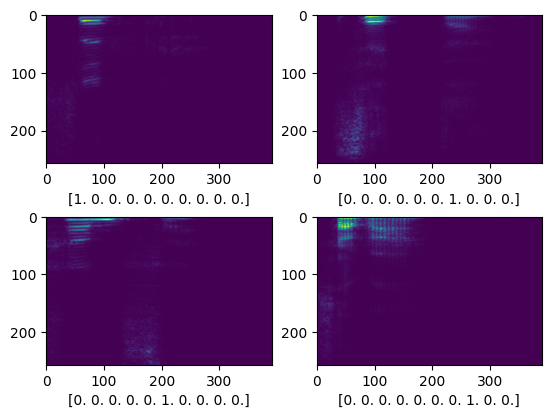

In [91]:
for i in range(4):
    filepath, label = trainings.shuffle(buffer_size=10000).as_numpy_iterator().next()
    spectrogram, label = preprocess(filepath, label)
    plt.subplot(2,2,i+1)
    plt.imshow(tf.transpose(spectrogram)[0])
    plt.xlabel(label)
plt.show()

Convert all to Spectogram

In [92]:
# train data
x_train = trainings.map(preprocess)
x_train = x_train.cache()
x_train = x_train.shuffle(buffer_size=1000)
x_train = x_train.batch(16) # 16 at a time
x_train = x_train.prefetch(8)
# test data
x_test = testings.map(preprocess)
x_test = x_test.cache()
x_test = x_test.shuffle(buffer_size=1000)
x_test = x_test.batch(16) # 16 at a time
x_test = x_test.prefetch(8)

In [93]:
# test one batch
samples, labels = x_train.as_numpy_iterator().next()
print(samples.shape)
print('\n',labels)

(16, 391, 257, 1)

 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


# 2. CNN no Attention

Design the CNN architecture

In [94]:
from keras.models import Sequential
from keras import layers

In [95]:
model=Sequential()
input_shape = (391, 257, 1)
model.add( layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape) )
model.add( layers.MaxPooling2D(pool_size=(2,2)) )
model.add( layers.Dropout(0.2) )
model.add( layers.Flatten() )
model.add( layers.Dense(32,activation='relu') )
model.add( layers.Dense(num_classes,activation='softmax') )
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 389, 255, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 194, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 192, 125, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 96, 62, 64)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 380928)            0         
                                                                 
 dense_8 (Dense)             (None, 32)               

Training

In [96]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy']
             )

In [97]:
model.fit(x_train,
          epochs=epochs,
          verbose=1,
          validation_data=x_test
          )

Epoch 1/4
75/75 [==============================] - 13s 72ms/step - loss: 1.6801 - accuracy: 0.4983 - val_loss: 1.0176 - val_accuracy: 0.6967
Epoch 2/4
75/75 [==============================] - 3s 40ms/step - loss: 0.4932 - accuracy: 0.8600 - val_loss: 1.0462 - val_accuracy: 0.7667
Epoch 3/4
75/75 [==============================] - 3s 39ms/step - loss: 0.2516 - accuracy: 0.9408 - val_loss: 1.0525 - val_accuracy: 0.7800
Epoch 4/4
75/75 [==============================] - 3s 38ms/step - loss: 0.1798 - accuracy: 0.9625 - val_loss: 1.2533 - val_accuracy: 0.7633


In [98]:
test_loss, test_acc = model.evaluate(x_test)
print('Test Accuracy = {:.2f} %:'.format(np.round(test_acc, 3)*100))

19/19 [==============================] - 0s 15ms/step - loss: 1.2533 - accuracy: 0.7633
Test Accuracy = 76.30 %:


# 3. CNN with Attention

Design the CNN architecture

In [99]:
inputs = layers.Input(shape=input_shape)

conv1 = layers.Conv2D(32,kernel_size=(3,3),activation='relu')(inputs)
pool1 = layers.MaxPool2D(pool_size=(2,2))(conv1)
#Attention1
attention_conv1 = layers.Conv2D(1, (3,3), padding='same', activation='sigmoid')(pool1)
attention_mul1 = layers.Multiply()([pool1, attention_conv1])
pool2 = layers.MaxPool2D(pool_size=(2,2))(attention_mul1)
##########
drop1 = layers.Dropout(0.2)(pool2)
flatten2 = layers.Flatten()(drop1)
dense2 = layers.Dense(32,activation='relu')(flatten2)
dense3 = layers.Dense(num_classes,activation='softmax')(dense2)

modelAtt = keras.Model(inputs=inputs, outputs=dense3)

modelAtt.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 391, 257, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 389, 255, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 194, 127, 32  0          ['conv2d_12[0][0]']              
 )                              )                                                           

Training

In [100]:
modelAtt.compile(optimizer=keras.optimizers.Adam(),
              loss= keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']
             )

In [101]:
modelAtt.fit(x_train,
          epochs=epochs,
          verbose=1,
          validation_data=x_test
          )

Epoch 1/4
75/75 [==============================] - 5s 33ms/step - loss: 1.5404 - accuracy: 0.5317 - val_loss: 1.1173 - val_accuracy: 0.7000
Epoch 2/4
75/75 [==============================] - 2s 31ms/step - loss: 0.6520 - accuracy: 0.8275 - val_loss: 1.2581 - val_accuracy: 0.6967
Epoch 3/4
75/75 [==============================] - 2s 33ms/step - loss: 0.3326 - accuracy: 0.9000 - val_loss: 1.0731 - val_accuracy: 0.7567
Epoch 4/4
75/75 [==============================] - 2s 33ms/step - loss: 0.2562 - accuracy: 0.9342 - val_loss: 1.0809 - val_accuracy: 0.8433


In [102]:
test_loss, test_acc = modelAtt.evaluate(x_test)
print('Test Accuracy = {:.2f} %:'.format(np.round(test_acc, 3)*100))

19/19 [==============================] - 0s 12ms/step - loss: 1.0809 - accuracy: 0.8433
Test Accuracy = 84.30 %:
